# Understanding the Object Detection Process

# Imports

In [ ]:
# !pip install torch==2.2.1

In [1]:
import torch
print("Pytorch Current Version:", torch.__version__)

Pytorch Current Version: 2.2.1+cu121


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from IPython.display import display

import torch
import torchvision
from torchvision.transforms.functional import to_pil_image
from torchvision.utils import draw_bounding_boxes
from torchvision.io.image import read_image

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Structure

In [5]:
def create_boxes(num_images, num_boxes_per_image, image_width, image_height):
    boxes = torch.zeros(num_images, num_boxes_per_image, 4)
    for i in range(num_images):
        for j in range(num_boxes_per_image):
            width = torch.rand(1) * (image_width / 4)
            height = torch.rand(1) * (image_height / 4)
            x1 = torch.rand(1) * (image_width - width)
            y1 = torch.rand(1) * (image_height - height)
            x2 = x1 + width
            y2 = y1 + height
            boxes[i, j, :] = torch.tensor([x1, y1, x2, y2], dtype=torch.float32)
    return boxes

In [6]:
images = [torch.rand(3, 600, 1200) for _ in range(4)]

In [7]:
images

[tensor([[[0.6723, 0.9844, 0.8092,  ..., 0.3176, 0.3722, 0.9909],
          [0.2477, 0.7546, 0.4785,  ..., 0.3414, 0.4079, 0.4508],
          [0.5484, 0.2871, 0.5298,  ..., 0.4347, 0.3556, 0.9778],
          ...,
          [0.3392, 0.5641, 0.1029,  ..., 0.1575, 0.4210, 0.3296],
          [0.7467, 0.3576, 0.7447,  ..., 0.3614, 0.9048, 0.8604],
          [0.6996, 0.2997, 0.7417,  ..., 0.7024, 0.2060, 0.8767]],
 
         [[0.2330, 0.6368, 0.7510,  ..., 0.8194, 0.3039, 0.1809],
          [0.5294, 0.5603, 0.9736,  ..., 0.6121, 0.4058, 0.8767],
          [0.8116, 0.1481, 0.8124,  ..., 0.2726, 0.8471, 0.0607],
          ...,
          [0.3013, 0.1711, 0.4456,  ..., 0.4562, 0.3980, 0.1213],
          [0.0656, 0.3786, 0.6386,  ..., 0.0864, 0.6819, 0.7334],
          [0.5094, 0.5178, 0.7029,  ..., 0.5135, 0.0232, 0.8141]],
 
         [[0.1188, 0.4081, 0.1482,  ..., 0.1028, 0.6409, 0.0788],
          [0.9935, 0.6165, 0.3644,  ..., 0.3954, 0.6467, 0.4717],
          [0.2335, 0.1013, 0.7582,  ...,

In [8]:
boxes = create_boxes(4, 10, 1200, 600)

In [9]:
boxes

tensor([[[ 654.5516,   46.1378,  900.8095,   64.3548],
         [ 735.6572,  207.1547,  813.1649,  290.5252],
         [ 339.0511,  465.6050,  396.5009,  507.6818],
         [  16.8302,   79.9789,  125.0567,  203.5026],
         [ 177.3990,  538.8466,  461.9108,  540.7637],
         [  13.3372,  393.3306,  298.1481,  539.1595],
         [ 148.5837,  236.5492,  304.3405,  349.9178],
         [ 597.4739,  205.2401,  891.7263,  244.3289],
         [ 958.9430,  443.3706, 1030.8516,  559.1310],
         [ 814.7012,  315.3958,  861.1171,  347.2893]],

        [[ 682.4489,  203.3940,  695.0918,  284.9932],
         [ 301.4083,  354.3442,  314.0352,  487.7320],
         [ 757.8155,  244.6360,  766.5663,  288.7342],
         [ 614.7315,  512.4491,  757.9714,  593.5669],
         [  22.4536,   63.5963,  147.2343,  196.3208],
         [ 397.4890,  163.6229,  608.1305,  264.4050],
         [ 169.7516,  292.2722,  280.4086,  439.0877],
         [ 558.4976,   90.5076,  642.6613,  185.9127],
        

In [10]:
labels = torch.randint(1, 91, (4, 10))

In [11]:
labels

tensor([[47, 77, 84, 54,  6, 70, 51, 31, 72, 21],
        [44, 29, 28, 85, 40, 57, 13, 81, 63, 90],
        [12, 38, 28, 13, 67,  6, 34, 84, 77, 11],
        [27, 90,  8, 75, 55, 63,  9, 40, 55, 20]])

In [12]:
targets = [{'boxes': boxes[i], 'labels': labels[i]} for i in range(len(images))]

In [13]:
targets

[{'boxes': tensor([[ 654.5516,   46.1378,  900.8095,   64.3548],
          [ 735.6572,  207.1547,  813.1649,  290.5252],
          [ 339.0511,  465.6050,  396.5009,  507.6818],
          [  16.8302,   79.9789,  125.0567,  203.5026],
          [ 177.3990,  538.8466,  461.9108,  540.7637],
          [  13.3372,  393.3306,  298.1481,  539.1595],
          [ 148.5837,  236.5492,  304.3405,  349.9178],
          [ 597.4739,  205.2401,  891.7263,  244.3289],
          [ 958.9430,  443.3706, 1030.8516,  559.1310],
          [ 814.7012,  315.3958,  861.1171,  347.2893]]),
  'labels': tensor([47, 77, 84, 54,  6, 70, 51, 31, 72, 21])},
 {'boxes': tensor([[682.4489, 203.3940, 695.0918, 284.9932],
          [301.4083, 354.3442, 314.0352, 487.7320],
          [757.8155, 244.6360, 766.5663, 288.7342],
          [614.7315, 512.4491, 757.9714, 593.5669],
          [ 22.4536,  63.5963, 147.2343, 196.3208],
          [397.4890, 163.6229, 608.1305, 264.4050],
          [169.7516, 292.2722, 280.4086, 439.

# Training

In [27]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights

In [28]:
weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT

In [29]:
model = fasterrcnn_resnet50_fpn_v2(weights=weights, box_score_thresh=0.9)

In [30]:
output = model(images, targets)

In [18]:
output

{'loss_classifier': tensor(0.4306, grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.0636, grad_fn=<DivBackward0>),
 'loss_objectness': tensor(4.5913, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(1.5440, grad_fn=<DivBackward0>)}

# Prediction

In [19]:
img = read_image("/content/drive/MyDrive/Colab Notebooks/imagenet_samples/Eskimo_dog.jpeg")

In [20]:
img

tensor([[[253, 254, 254,  ..., 241, 242, 242],
         [253, 254, 254,  ..., 242, 244, 242],
         [253, 254, 255,  ..., 243, 243, 241],
         ...,
         [255, 254, 255,  ..., 252, 254, 255],
         [255, 254, 255,  ..., 255, 254, 255],
         [255, 253, 254,  ..., 254, 254, 255]],

        [[255, 255, 255,  ..., 232, 233, 233],
         [255, 255, 255,  ..., 233, 232, 233],
         [255, 255, 255,  ..., 231, 230, 229],
         ...,
         [255, 254, 255,  ..., 252, 254, 255],
         [255, 254, 255,  ..., 255, 254, 255],
         [255, 253, 254,  ..., 254, 254, 255]],

        [[254, 255, 255,  ..., 215, 216, 216],
         [254, 255, 255,  ..., 216, 216, 216],
         [254, 255, 255,  ..., 215, 214, 213],
         ...,
         [255, 254, 255,  ..., 252, 254, 255],
         [255, 254, 255,  ..., 255, 254, 255],
         [255, 253, 254,  ..., 254, 254, 255]]], dtype=torch.uint8)

In [21]:
preprocess = weights.transforms()

In [22]:
input_tensor = preprocess(img)

In [23]:
input_batch = input_tensor.unsqueeze(0)

In [31]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [32]:
prediction = model(input_batch)

In [33]:
prediction

[{'boxes': tensor([[ 73.1516,  13.4315, 242.8971, 186.4080]], grad_fn=<StackBackward0>),
  'labels': tensor([17]),
  'scores': tensor([0.9851], grad_fn=<IndexBackward0>)}]

In [34]:
prediction = model(input_batch)[0]

In [35]:
labels = [weights.meta["categories"][i] for i in prediction["labels"]]

In [36]:
labels

['cat']

# Visualize Predictions

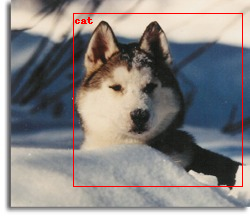

In [37]:
box = draw_bounding_boxes(img, boxes=prediction["boxes"],
                          labels=labels, colors="red")

im = to_pil_image(box.detach())
display(im)

# plt.imshow(im)
# plt.axis('off')
# plt.show()

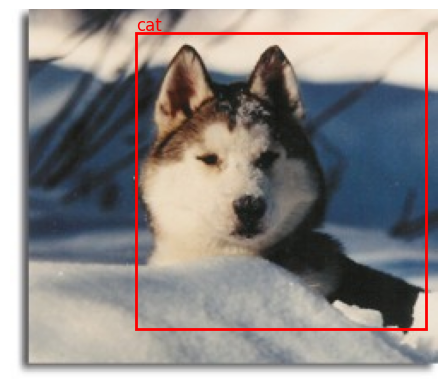

In [38]:
img = to_pil_image(input_tensor)
fig, ax = plt.subplots(1)
ax.imshow(img)
ax.axis('off')

for box, label in zip(prediction['boxes'], labels):
    box = box.detach().numpy()
    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    plt.text(box[0], box[1]-10, label, color='red', fontsize=12, verticalalignment='top')

plt.show()

In [ ]:
# yaml xml